In [1]:
%cd /mnt/i/Yuki/workspace/exercises/nlp_100_knock

/mnt/i/Yuki/workspace/exercises/nlp_100_knock


https://nlp100.github.io/ja/ch05.html

# 準備

In [2]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

In [3]:
parsed_result_path = 'Question_40_49/ai.ja/ai.ja.txt.parsed'

In [4]:
with open(parsed_result_path, 'r', encoding='utf8') as f:
    parsed_result = f.read()

# 問題

## 40. 係り受け解析結果の読み込み (形態素)

## 41. 係り受け解析結果の読み込み (文節・係り受け)

In [5]:
class Morph:
    def __init__(self, word_info):
        surface, info_line = word_info.split('\t')
        grammer_infos = info_line.split(',')
        self.surface = surface
        self.pos = grammer_infos[0]
        self.pos1 = grammer_infos[1]
        self.base = grammer_infos[6]
    
    def __str__(self):
        return f'surface: {self.surface}'

class Chunk:
    def __init__(self, clause):
        self.morphs = []
        for word_info in clause[1:]:
            self.morphs.append(Morph(word_info))

        self.dst = int(clause[0].split()[2][:-1])
        self.srcs = []

    def register_src(self, src):
        self.srcs.append(src)
        
    def __str__(self):
        return '\n'.join([f'surface: {morph.surface}' for morph in self.morphs]) 

In [6]:
sentences = []
sentence = []
clause = []
for line in parsed_result.split('\n'):
    if line.startswith('*'):
        if clause:
            sentence.append(clause)
            clause = []
        clause.append(line)
    elif line == 'EOS':
        if clause:
            sentence.append(clause)
            clause = []
        if sentence:
            sentences.append(sentence)
            sentence = []
    else:
        clause.append(line)

In [7]:
sentences

[[['* 0 -1D 1/1 0.000000',
   '人工\t名詞,一般,*,*,*,*,人工,ジンコウ,ジンコー',
   '知能\t名詞,一般,*,*,*,*,知能,チノウ,チノー']],
 [['* 0 17D 1/1 0.388993',
   '人工\t名詞,一般,*,*,*,*,人工,ジンコウ,ジンコー',
   '知能\t名詞,一般,*,*,*,*,知能,チノウ,チノー'],
  ['* 1 17D 2/3 0.613549',
   '（\t記号,括弧開,*,*,*,*,（,（,（',
   'じん\t名詞,一般,*,*,*,*,じん,ジン,ジン',
   'こうち\t名詞,一般,*,*,*,*,こうち,コウチ,コーチ',
   'のう\t助詞,終助詞,*,*,*,*,のう,ノウ,ノー',
   '、\t記号,読点,*,*,*,*,、,、,、',
   '、\t記号,読点,*,*,*,*,、,、,、'],
  ['* 2 3D 0/0 0.758984', 'AI\t名詞,一般,*,*,*,*,*'],
  ['* 3 17D 1/5 0.517898',
   '〈\t記号,括弧開,*,*,*,*,〈,〈,〈',
   'エーアイ\t名詞,固有名詞,一般,*,*,*,*',
   '〉\t記号,括弧閉,*,*,*,*,〉,〉,〉',
   '）\t記号,括弧閉,*,*,*,*,）,）,）',
   'と\t助詞,格助詞,引用,*,*,*,と,ト,ト',
   'は\t助詞,係助詞,*,*,*,*,は,ハ,ワ',
   '、\t記号,読点,*,*,*,*,、,、,、'],
  ['* 4 5D 2/2 1.035972',
   '「\t記号,括弧開,*,*,*,*,「,「,「',
   '『\t記号,括弧開,*,*,*,*,『,『,『',
   '計算\t名詞,サ変接続,*,*,*,*,計算,ケイサン,ケイサン'],
  ['* 5 9D 0/3 1.243687',
   '（\t記号,括弧開,*,*,*,*,（,（,（',
   '）\t記号,括弧閉,*,*,*,*,）,）,）',
   '』\t記号,括弧閉,*,*,*,*,』,』,』',
   'という\t助詞,格助詞,連語,*,*,*,という,トイウ,トユウ'],
  ['* 6 

In [8]:
chunks_list = [[Chunk(clause) for clause in sentence] for sentence in sentences]
for chunks in chunks_list:
    for src, chunk in enumerate(chunks):
        if chunk.dst < 0:
            continue
        chunks[chunk.dst].register_src(src)

## 42. 係り元と係り先の文節の表示

In [9]:
data = []
for i, chunks in enumerate(chunks_list):
    for chunk in chunks:
        src_surface = ''.join([morph.surface for morph in chunk.morphs if morph.pos != '記号'])
        if chunk.dst >= 0:
            dst_surface = ''.join([morph.surface for morph in chunks[chunk.dst].morphs if morph.pos != '記号'])
        else:
            dst_surface = 'EOS'
        data.append([i, src_surface, dst_surface])

df = pd.DataFrame(data, columns=['文章ID', '係り元', '係り先'])
df.to_csv('Question_40_49/q42.csv', index=False)

In [10]:
df

,文章ID,係り元,係り先
0,0,人工知能,EOS
1,1,人工知能,語
2,1,じんこうちのう,語
3,1,AI,エーアイとは
4,1,エーアイとは,語
...,...,...,...
2939,82,発言し,答えている
2940,82,伊勢田は,答えている
2941,82,決着は,つかないでしょうねと
2942,82,つかないでしょうねと,答えている


## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

In [11]:
data = []
for i, chunks in enumerate(chunks_list):
    for chunk in chunks:
        noun_in_src = np.any([morph.pos == '名詞' and morph.pos1 == '一般' for morph in chunk.morphs])
        if not noun_in_src:
            continue
        src_surface = ''.join([morph.surface for morph in chunk.morphs if morph.pos != '記号'])

        if chunk.dst >= 0:
            verb_in_dst = np.any([morph.pos == '動詞' for morph in chunks[chunk.dst].morphs])
            if not verb_in_dst:
                continue
            dst_surface = ''.join([morph.surface for morph in chunks[chunk.dst].morphs if morph.pos != '記号'])

            data.append([i, src_surface, dst_surface])

df = pd.DataFrame(data, columns=['文章ID', '係り元', '係り先'])
df.to_csv('Question_40_49/q43.csv', index=False)

In [12]:
df

,文章ID,係り元,係り先
0,1,道具を,用いて
1,1,知能を,研究する
2,1,一分野を,指す
3,1,知的行動を,代わって
4,1,人間に,代わって
...,...,...,...
684,81,具体的に,定義しない
685,81,哲学者が,持っている
686,81,興味を,持っている
687,81,物理学者とは,違う


## 44. 係り受け木の可視化

In [13]:
def show_dependency_graph(chunks):
    G = nx.DiGraph()
    for i, chunk in enumerate(chunks):
        if chunk.dst != -1:
            nx.add_path(G, [i, chunk.dst])

    nx.draw_networkx(G)
    plt.show()

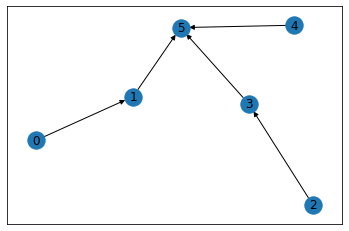

In [14]:
show_dependency_graph(chunks_list[2])

## 45. 動詞の格パターンの抽出

In [15]:
data = []
for i, chunks in enumerate(chunks_list):
    for chunk in chunks:
        verb_in_dst = np.any([morph.pos == '動詞' for morph in chunk.morphs])
        if not verb_in_dst:
            continue
        src_surface = ''.join([morph.surface for morph in chunk.morphs if morph.pos != '記号'])

        particles = []
        for src in chunk.srcs:
            for morph in chunks[src].morphs[::-1]:
                if morph.pos == '助詞' and morph.base not in particles:
                    particles.append(morph.base)
                    break

        particles = ' '.join(sorted(particles))
        data.append([i, src_surface, particles])

df = pd.DataFrame(data, columns=['文章ID', '述語', '格'])
df.to_csv('Question_40_49/q45.csv', index=False)

In [16]:
df

,文章ID,述語,格
0,1,用いて,を
1,1,研究する,て を
2,1,指す,を
3,1,代わって,に を
4,1,行わせる,て に
...,...,...,...
703,82,思いますが,は
704,82,つくのでしょうかと,か が て
705,82,発言し,と は
706,82,つかないでしょうねと,は


## 46. 動詞の格フレーム情報の抽出

In [17]:
data = []
for i, chunks in enumerate(chunks_list):
    for chunk in chunks:
        verb_in_dst = np.any([morph.pos == '動詞' for morph in chunk.morphs])
        if not verb_in_dst:
            continue
        src_surface = ''.join([morph.surface for morph in chunk.morphs if morph.pos != '記号'])

        particles = []
        terms = []
        for src in chunk.srcs:
            for morph in chunks[src].morphs[::-1]:
                if morph.pos == '助詞':
                    if morph.base not in particles:
                        particles.append(morph.base)
                    term = ''.join([morph.surface for morph in chunks[src].morphs if morph.pos != '記号'])
                    if term not in terms:
                        terms.append(term)
                    break

        particles = ' '.join(sorted(particles))
        terms = ' '.join(sorted(terms))
        data.append([i, src_surface, particles, terms])

df = pd.DataFrame(data, columns=['文章ID', '述語', '格', '項'])
df.to_csv('Question_40_49/q46.csv', index=False)

In [18]:
df

,文章ID,述語,格,項
0,1,用いて,を,道具を
1,1,研究する,て を,用いて 知能を
2,1,指す,を,一分野を
3,1,代わって,に を,人間に 知的行動を
4,1,行わせる,て に,コンピューターに 代わって
...,...,...,...,...
703,82,思いますが,は,明らかになったとは
704,82,つくのでしょうかと,か が て,何か 思いますが 決着が 行ってきました
705,82,発言し,と は,つくのでしょうかと 須藤は
706,82,つかないでしょうねと,は,決着は


## 47. 機能動詞構文のマイニング

In [19]:
def is_nominal(morphs):
    nominal_found = ''
    for morph in morphs:
        if nominal_found and morph.base == 'を':
            return nominal_found + morph.base
        if morph.pos1 == 'サ変接続':
            nominal_found = morph.base
        else:
            nominal_found = ''
    
    return ''

data = []
for i, chunks in enumerate(chunks_list):
    for chunk in chunks:
        nominal_in_dst = is_nominal(chunk.morphs)
        if not nominal_in_dst:
            continue
        src_surface = nominal_in_dst

        for morph in chunks[chunk.dst].morphs[::-1]:
            if morph.pos == '動詞' and morph.pos1 == '自立':
                src_surface += morph.base
                break
        else:
            continue

        particles = []
        terms = []
        for src in chunk.srcs:
            for morph in chunks[src].morphs[::-1]:
                if morph.pos == '助詞':
                    if morph.base not in particles:
                        particles.append(morph.base)
                    term = ''.join([morph.surface for morph in chunks[src].morphs if morph.pos != '記号'])
                    if term not in terms:
                        terms.append(term)
                    break

        particles = ' '.join(sorted(particles))
        terms = ' '.join(sorted(terms))
        data.append([i, src_surface, particles, terms])

df = pd.DataFrame(data, columns=['文章ID', '述語', '格', '項'])
df.to_csv('Question_40_49/q47.csv', index=False)

In [20]:
df

,文章ID,述語,格,項
0,1,行動を代わる,の,問題解決などの
1,3,判断をする,の,専門家の
2,3,処理を用いる,,
3,3,記述をする,の,知能の
4,4,注目を集める,,
...,...,...,...,...
70,72,実現をする,の,Godheadの
71,73,話をする,の,異界の
72,76,疎通を行う,,
73,78,勘違いをする,,


## 48. 名詞から根へのパスの抽出

In [21]:
data = []
for i, chunks in enumerate(chunks_list):
    for chunk in chunks:
        noun_in_dst = np.any([morph.pos == '名詞' and morph.pos1 == '一般' for morph in chunk.morphs])
        if not noun_in_dst:
            continue
        nodes = []
        nodes.append(''.join([morph.surface for morph in chunk.morphs if morph.pos != '記号']))
        dst = chunk.dst
        while dst != -1:
            nodes.append(''.join([morph.surface for morph in chunks[dst].morphs if morph.pos != '記号']))
            dst = chunks[dst].dst
        data.append([i, ' -> '.join(nodes)])

df = pd.DataFrame(data, columns=['文章ID', 'パス'])
df.to_csv('Question_40_49/q48.csv', index=False)

In [22]:
df

,文章ID,パス
0,0,人工知能
1,1,人工知能 -> 語 -> 研究分野とも -> される
2,1,じんこうちのう -> 語 -> 研究分野とも -> される
3,1,AI -> エーアイとは -> 語 -> 研究分野とも -> される
4,1,概念と -> 道具を -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野...
...,...,...
1268,81,物理学者とは -> 違う -> ことは -> 確かでしょうと -> している -> 述べている
1269,81,物理学者と -> 哲学者の -> ものの -> 見え方の -> 違いというのは -> 大きい...
1270,81,哲学者の -> ものの -> 見え方の -> 違いというのは -> 大きいのかもしれませんと...
1271,81,見え方の -> 違いというのは -> 大きいのかもしれませんと -> 述べている


## 49. 名詞間の係り受けパスの抽出

In [23]:
data = []
for i, chunks in enumerate(chunks_list):
    cache_dict = {}
    for j1, chunk in enumerate(chunks):
        for j2 in range(j1 + 1, len(chunks)):
            noun_in_dst = np.any([morph.pos == '名詞' and morph.pos1 == '一般' for morph in chunk.morphs])
            if not noun_in_dst:
                break

            noun_in_dst = np.any([morph.pos == '名詞' and morph.pos1 == '一般' for morph in chunks[j2].morphs])
            if not noun_in_dst:
                continue

            if j1 not in cache_dict:
                nums = []
                nums.append(j1)
                dst = chunk.dst
                while dst != -1:
                    nums.append(dst)
                    dst = chunks[dst].dst

                cache_dict[j1] = nums[::-1]

            if j2 not in cache_dict:
                nums = []
                nums.append(j2)
                dst = chunks[j2].dst
                while dst != -1:
                    nums.append(dst)
                    dst = chunks[dst].dst

                cache_dict[j2] = nums[::-1]

            k = 0
            while k < len(cache_dict[j1]) and k < len(cache_dict[j2]):
                if cache_dict[j1][k] == cache_dict[j2][k]:
                    k += 1
                else:
                    break
            
            surfaces = []

            nodes1 = []
            for l, num in enumerate(cache_dict[j1][k:][::-1]):
                if l == 0:
                    node = ''
                    found_noun = False
                    for morph in chunks[num].morphs:
                        if morph.pos != '記号':
                            if morph.pos == '名詞' and morph.pos1 == '一般':
                                if not found_noun:
                                    node += 'X'
                                    found_noun = True
                            else:
                                node += morph.surface
                    nodes1.append(node)
                else:
                    nodes1.append(''.join([morph.surface for morph in chunks[num].morphs if morph.pos != '記号']))        
            surfaces.append(' -> '.join(nodes1))

            if len(cache_dict[j2]) == k:
                num = cache_dict[j1][k - 1]
                surfaces.append(''.join([morph.surface for morph in chunks[num].morphs if morph.pos != '記号']))
                data.append([i, ' -> '.join(surfaces)])

            else:
                nodes2 = []
                for l, num in enumerate(cache_dict[j2][k:][::-1]):
                    if l == 0:
                        node = ''
                        found_noun = False
                        for morph in chunks[num].morphs:
                            if morph.pos != '記号':
                                if morph.pos == '名詞' and morph.pos1 == '一般':
                                    if not found_noun:
                                        node += 'Y'
                                        found_noun = True
                                else:
                                    node += morph.surface
                        nodes2.append(node)
                    else:
                        nodes2.append(''.join([morph.surface for morph in chunks[num].morphs if morph.pos != '記号']))
                surfaces.append(' -> '.join(nodes2))

                num = cache_dict[j1][k - 1]
                surfaces.append(''.join([morph.surface for morph in chunks[num].morphs if morph.pos != '記号']))

                data.append([i, ' | '.join(surfaces)])

df = pd.DataFrame(data, columns=['文章ID', 'パス'])
df.to_csv('Question_40_49/q49.csv', index=False)

In [24]:
df

,文章ID,パス
0,1,X | Yのう | 語
1,1,X | Y -> エーアイとは | 語
2,1,X | Yと -> 道具を -> 用いて -> 研究する -> 計算機科学 -> の -> ...
3,1,X | Y -> という -> 道具を -> 用いて -> 研究する -> 計算機科学 ->...
4,1,X | Yを -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野を ->...
...,...,...
18013,81,Xとは -> 違う -> ことは -> 確かでしょうと -> している | Y者の -> も...
18014,81,Xとは -> 違う -> ことは -> 確かでしょうと -> している | Y方の -> 違...
18015,81,Xと -> 哲学者の
18016,81,Xと -> 哲学者の -> ものの -> 見え方の
